In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils

# Preprocess images, code from github https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

# This cell is meant to be run only once to preprocess the images and save them in a new folder
# You only need to run this cell once, after the folder has been created, you can ignore it

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	

In [ ]:
# This cell is meant to be run only once to preprocess the images and save them in a new folder
# You only need to run this cell once, after the folder has been created, you can ignore it

training = "Training"
testing = "Testing"
training_dir = os.listdir(training)
testing_dir = os.listdir(testing)

IMG_SIZE = 64

# create training dirs
for dir in training_dir:
    save_path = 'cleaned/Training/'+ dir
    path = os.path.join(training,dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path,img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

# create testing dirs
for dir in testing_dir:
    save_path = 'cleaned/Testing/'+ dir
    path = os.path.join(testing,dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path,img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

## Training and testing with different methods

In [1]:
from sklearn.datasets import load_files
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
import mnist
import os
import cv2
import numpy as np

IMG_SIZE = 64

def super_simple_load(data_dir, img_size=(IMG_SIZE, IMG_SIZE)):
    X, y = [], []
    
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue
            
        # each label is assigned a numeric value
        label = len(set(y))
        
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, 0)  # Grayscale
                img = cv2.resize(img, img_size).flatten() / 255.0
                
                X.append(img)
                y.append(label)
    
    return np.array(X), np.array(y)

In [2]:
from sklearn.model_selection import train_test_split

# load the data and split them into train, validation and test sets
X_train_full, y_train_full = super_simple_load("training/")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=20,
    stratify=y_train_full
)
X_test, y_test = super_simple_load("testing/")


In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

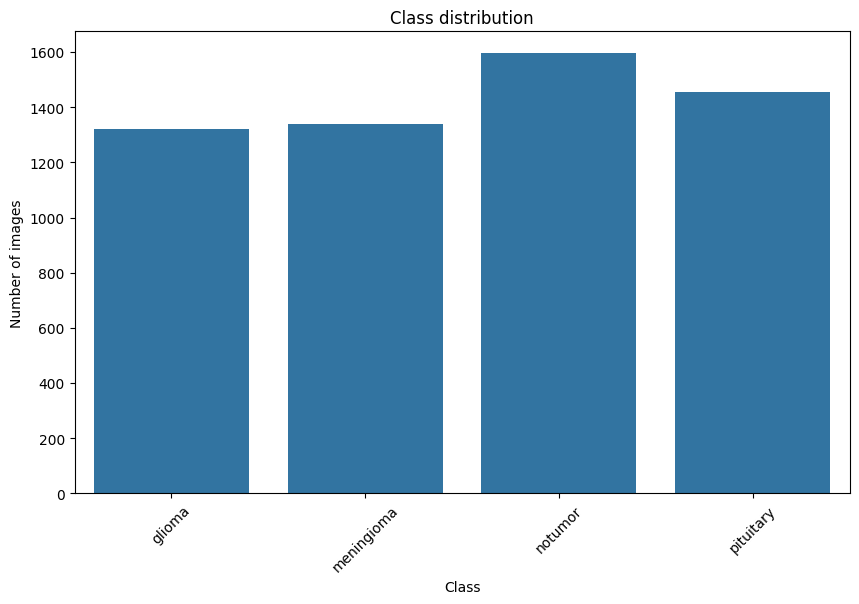

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize class distribution
classes = ["glioma", "meningioma", "notumor", "pituitary"]
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_full)
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.show()


### Logistic Regression

C:\Users\danit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Log loss: 0.3930073073189831
Training accuracy: 0.9739145658263305
Validation accuracy: 0.8713910761154856
Test accuracy: 0.88558352402746


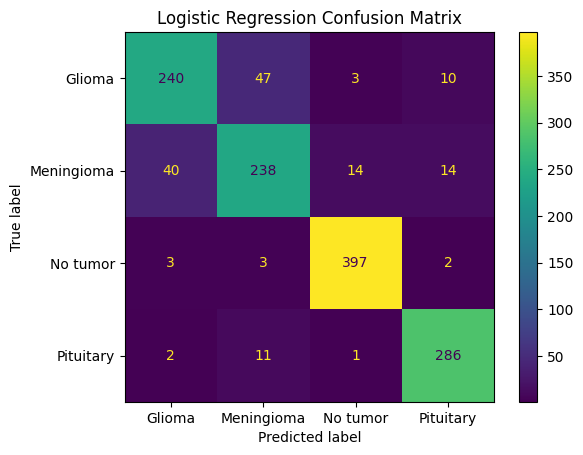

In [4]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Get probability predictions instead of class predictions for log_loss
y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)

train_accuracy = model.score(X_train_full, y_train_full)
val_accuracy = model.score(X_val, y_val)
test_accuracy = model.score(X_test, y_test)

print(f"Log loss: {loss}")
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Also create confusion matrix for visualization
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()



### CNN with keras

Epoch 1/13


C:\Users\danit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4765 - loss: 1.1212 - val_accuracy: 0.7095 - val_loss: 0.7901
Epoch 2/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - accuracy: 0.7159 - loss: 0.7551 - val_accuracy: 0.7883 - val_loss: 0.5974
Epoch 3/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.7649 - loss: 0.6133 - val_accuracy: 0.7515 - val_loss: 0.6208
Epoch 4/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.8131 - loss: 0.5028 - val_accuracy: 0.8661 - val_loss: 0.3817
Epoch 5/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.8299 - loss: 0.4521 - val_accuracy: 0.8836 - val_loss: 0.3333
Epoch 6/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.8580 - loss: 0.3813 - val_accuracy: 0.8679 - val_loss: 0.3374
Epoch 7/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 173ms/step - accuracy: 0.8772 - loss: 0.3372 - val_accuracy: 0.8933 - val_loss: 0.2924
Epoch 8/13
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 172ms/step - accuracy: 0.8963 - loss: 0.2871 - val_

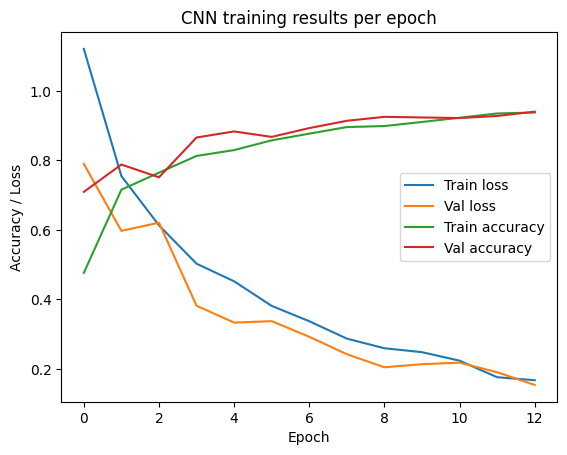

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

X_train_new = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val_new = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_new = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64,64,1)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(128, (3,3), activation='relu'),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_new,
    to_categorical(y_train, num_classes=4),
    epochs=13,
    validation_data=(X_val_new, to_categorical(y_val, num_classes=4)),
)

model.evaluate(X_test_new, to_categorical(y_test, num_classes=4))

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy / Loss")
plt.title("CNN training results per epoch")
plt.legend()
plt.show()